# Homework 2 - Wikipedia Web Traffic Time Series

У вас є дані про відвідування 1000 сторінок Вікіпедії з різних країн та різних девайсів (дані взяті з [Kaggle змагання](https://www.kaggle.com/c/web-traffic-time-series-forecasting))

*wikipedia_train* и *wikipedia_test* - містять дані про трафік. Це файли CSV, де кожен рядок відповідає певній статті, і кожен стовпець відповідає конкретній даті. У деяких записах дані відсутні. Назви сторінок містять проект Вікіпедії (наприклад, en.wikipedia.org), тип доступу (наприклад, desktop) та тип агента (наприклад, spider). Кожне ім'я статті має такий формат: «name_project_access_agent» (наприклад, «AKB48_zh.wikipedia.org_all-access_spider»).

Вам треба відповісти на [питання](https://forms.gle/tx4gSVpCn6cvHMYY6) і спробувати зробити найпростішу модель, яка зможе передбачати майбутні відвідування.

Ось приклади часових рядів відвідуваності сторінок Вікіпедії (*сині* - навчальна вибірка, *зелені* - передбачення моделі переможця змагання на Kaggle, *помаранчеві* - реальні значення):
![Wikipedia Web Traffic Time Series](https://image.ibb.co/cUpEJa/predictions.png)

In [1]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [4]:
train = pd.read_csv("./data/wikipedia_train.csv")
test = pd.read_csv("./data/wikipedia_test.csv")

In [ ]:
print(f"train.shape: {train.shape}, test.shape: {test.shape}")

train.shape: (939, 429), test.shape: (939, 63)


In [ ]:
train.head(3)

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2016-08-22,2016-08-23,2016-08-24,2016-08-25,2016-08-26,2016-08-27,2016-08-28,2016-08-29,2016-08-30,2016-08-31
0,15._November_de.wikipedia.org_desktop_all-agents,32.0,26.0,22.0,22.0,29.0,49.0,20.0,27.0,19.0,...,29.0,23.0,31.0,25.0,27.0,23.0,17.0,26.0,23.0,37.0
1,2012_(film)_fr.wikipedia.org_all-access_spider,2.0,3.0,5.0,3.0,5.0,3.0,7.0,8.0,7.0,...,5.0,5.0,6.0,5.0,4.0,11.0,2.0,0.0,7.0,5.0
2,2016_FIFA_U-20女子ワールドカップ_ja.wikipedia.org_all-a...,1.0,3.0,2.0,2.0,1.0,10.0,2.0,1.0,4.0,...,4.0,3.0,2.0,3.0,2.0,4.0,2.0,0.0,5.0,4.0


In [ ]:
test.head(3)

,Page,2016-09-10,2016-09-11,2016-09-12,2016-09-13,2016-09-14,2016-09-15,2016-09-16,2016-09-17,2016-09-18,...,2016-11-01,2016-11-02,2016-11-03,2016-11-04,2016-11-05,2016-11-06,2016-11-07,2016-11-08,2016-11-09,2016-11-10
0,15._November_de.wikipedia.org_desktop_all-agents,43.0,29.0,19.0,33.0,30.0,28.0,27.0,15.0,22.0,...,66.0,78.0,119.0,78.0,63.0,89.0,141.0,146.0,120.0,147.0
1,2012_(film)_fr.wikipedia.org_all-access_spider,6.0,31.0,23.0,12.0,1.0,24.0,9.0,30.0,4.0,...,2.0,0.0,3.0,2.0,6.0,1.0,2.0,1.0,3.0,2.0
2,2016_FIFA_U-20女子ワールドカップ_ja.wikipedia.org_all-a...,4.0,2.0,0.0,5.0,3.0,2.0,4.0,3.0,0.0,...,16.0,17.0,11.0,18.0,20.0,25.0,13.0,19.0,22.0,33.0


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 939 entries, 0 to 938
Columns: 429 entries, Page to 2016-08-31
dtypes: float64(428), object(1)
memory usage: 3.1+ MB


In [ ]:
train.isnull().sum()

Page           0
2015-07-01    91
2015-07-02    91
2015-07-03    91
2015-07-04    90
              ..
2016-08-27    12
2016-08-28    21
2016-08-29    14
2016-08-30    14
2016-08-31    14
Length: 429, dtype: int64

Fill all NaN values with 0 

In [ ]:
train.fillna(0, inplace=True)
train.isnull().sum().sum()

0

## Data Analysis

In [ ]:
def get_language(page):
    res = re.search('[a-z][a-z].wikipedia.org',page)
    if res:
        return res.group(0)[0:2]
    return 'na'

Create table to work with information about language and mean values of visits

In [ ]:
train_temp = train.copy()
train_temp['language'] = train_temp['Page'].map(lambda x: get_language(x))
train_temp['language'].value_counts()

en    140
fr    128
ja    124
na    124
de    122
ru    102
es    101
zh     98
Name: language, dtype: int64

In [ ]:
train_temp['mean_visits'] = train_temp.iloc[:, 1:-1].mean(axis=1)
train_temp['mean_visits']

0       67.929907
1        5.172897
2        3.149533
3       18.841121
4      100.820093
          ...    
934     43.955607
935    477.331776
936    222.500000
937     97.866822
938    122.672897
Name: mean_visits, Length: 939, dtype: float64

In [ ]:
train_temp[['Page', 'language', 'mean_visits']].loc[train_temp.groupby(['language'])['mean_visits'].idxmax()]

,Page,language,mean_visits
243,Frankreich_de.wikipedia.org_desktop_all-agents,de,2840.254673
624,World_War_II_en.wikipedia.org_all-access_all-a...,en,29360.021028
172,Especial:BúsquedaDeEnlaces_es.wikipedia.org_al...,es,17863.411215
242,France_fr.wikipedia.org_desktop_all-agents,fr,6543.698598
921,関ジャニ∞_ja.wikipedia.org_mobile-web_all-agents,ja,3532.869159
102,Category:Videos_of_male_ejaculation_commons.wi...,na,1214.735981
180,Facebook_ru.wikipedia.org_desktop_all-agents,ru,2171.240654
48,BIGBANG_zh.wikipedia.org_desktop_all-agents,zh,2194.481308


## Forecasting

Потрібно перетворитиь `train` дані в наступний формат:

In [ ]:
# train.head()

,Page,date,Visits
0,15._November_de.wikipedia.org_desktop_all-agents,2015-07-01,32
1,2012_(film)_fr.wikipedia.org_all-access_spider,2015-07-01,2
2,2016_FIFA_U-20女子ワールドカップ_ja.wikipedia.org_all-a...,2015-07-01,1
3,2016_UEFA_Europa_League_Final_en.wikipedia.org...,2015-07-01,3
4,2016_in_video_gaming_en.wikipedia.org_all-acce...,2015-07-01,24


In [ ]:
train = pd.melt(train, id_vars=['Page'], var_name='date', value_name='Visits')
train.head()

,Page,date,Visits
0,15._November_de.wikipedia.org_desktop_all-agents,2015-07-01,32.0
1,2012_(film)_fr.wikipedia.org_all-access_spider,2015-07-01,2.0
2,2016_FIFA_U-20女子ワールドカップ_ja.wikipedia.org_all-a...,2015-07-01,1.0
3,2016_UEFA_Europa_League_Final_en.wikipedia.org...,2015-07-01,3.0
4,2016_in_video_gaming_en.wikipedia.org_all-acce...,2015-07-01,24.0


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 401892 entries, 0 to 401891
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Page    401892 non-null  object 
 1   date    401892 non-null  object 
 2   Visits  401892 non-null  float64
dtypes: float64(1), object(2)
memory usage: 9.2+ MB


Change type of 'date' column from *'object'* to *'datetime'*

In [ ]:
train['date'] = pd.to_datetime(train['date'])
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 401892 entries, 0 to 401891
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   Page    401892 non-null  object        
 1   date    401892 non-null  datetime64[ns]
 2   Visits  401892 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 9.2+ MB


Таким чином у вас кожен рядок містить набір фіч (`Page`, `date`) та цільову змінну (`Visits`). Перетворити дані на такий формат допоможе функція `pd.melt()` (https://pandas.pydata.org/pandas-docs/stable/generated/pandas.melt.html)

Оцінювати якість передбачень ми будемо за допомогою [SMAPE](https://en.wikipedia.org/wiki/Symmetric_mean_absolute_percentage_error) :

In [ ]:
def pandas_smape(df):
    df.fillna(0, inplace=True)
    df["SMAPE"] = 200 * np.abs(df["Visits"] - df["pred_Visits"]) / (df["Visits"] + df["pred_Visits"])
    df["SMAPE"].fillna(0, inplace=True)
    return np.mean(df["SMAPE"])

Щоб оцінити точність прогнозу потрібно перетворити `test` дані в наступний формат:

In [ ]:
# prediction.head()

,Page,date,Visits,pred_Visits
0,15._November_de.wikipedia.org_desktop_all-agents,2016-09-10,43,37
1,2012_(film)_fr.wikipedia.org_all-access_spider,2016-09-10,6,5
2,2016_FIFA_U-20女子ワールドカップ_ja.wikipedia.org_all-a...,2016-09-10,4,4
3,2016_UEFA_Europa_League_Final_en.wikipedia.org...,2016-09-10,15,14
4,2016_in_video_gaming_en.wikipedia.org_all-acce...,2016-09-10,101,173


In [ ]:
test = pd.melt(test.copy(), id_vars=['Page'], var_name='date', value_name='Visits')
test.head()

,Page,date,Visits
0,15._November_de.wikipedia.org_desktop_all-agents,2016-09-10,43.0
1,2012_(film)_fr.wikipedia.org_all-access_spider,2016-09-10,6.0
2,2016_FIFA_U-20女子ワールドカップ_ja.wikipedia.org_all-a...,2016-09-10,4.0
3,2016_UEFA_Europa_League_Final_en.wikipedia.org...,2016-09-10,15.0
4,2016_in_video_gaming_en.wikipedia.org_all-acce...,2016-09-10,101.0


In [ ]:
test['date'] = pd.to_datetime(test['date'])
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58218 entries, 0 to 58217
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Page    58218 non-null  object        
 1   date    58218 non-null  datetime64[ns]
 2   Visits  57244 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 1.3+ MB


І потім викликати функцію для підрахунку метрики:

In [ ]:
# pandas_smape(prediction)

### Last day baseline

Потрібно зробити прогноз на основі відвідувань в останній відомий нам день з train (продублювати значення для кожного дня у test)

In [ ]:
last_date = train['date'].max()
last_date

Timestamp('2016-08-31 00:00:00')

In [ ]:
train_last_date = train[train['date'] == last_date][['Page', 'Visits']].rename(columns={'Visits': 'pred_Visits'})
train_last_date.head()

,Page,pred_Visits
400953,15._November_de.wikipedia.org_desktop_all-agents,37.0
400954,2012_(film)_fr.wikipedia.org_all-access_spider,5.0
400955,2016_FIFA_U-20女子ワールドカップ_ja.wikipedia.org_all-a...,4.0
400956,2016_UEFA_Europa_League_Final_en.wikipedia.org...,14.0
400957,2016_in_video_gaming_en.wikipedia.org_all-acce...,173.0


In [ ]:
prediction_last_day = test.join(train_last_date.set_index('Page'), on='Page')
prediction_last_day.head()

,Page,date,Visits,pred_Visits
0,15._November_de.wikipedia.org_desktop_all-agents,2016-09-10,43.0,37.0
1,2012_(film)_fr.wikipedia.org_all-access_spider,2016-09-10,6.0,5.0
2,2016_FIFA_U-20女子ワールドカップ_ja.wikipedia.org_all-a...,2016-09-10,4.0,4.0
3,2016_UEFA_Europa_League_Final_en.wikipedia.org...,2016-09-10,15.0,14.0
4,2016_in_video_gaming_en.wikipedia.org_all-acce...,2016-09-10,101.0,173.0


In [ ]:
pandas_smape(prediction_last_day)

54.16127748085961

Create function for visualization information about real and predicted values for 2 page: *15._November_de.wikipedia.org_desktop_all-agents* and *Rihanna_es.wikipedia.org_all-access_spider*

In [ ]:
def plot_real_predict(prediction_df, title):
    page_1 = prediction_df[prediction_df['Page'] == '15._November_de.wikipedia.org_desktop_all-agents']
    page_2 = prediction_df[prediction_df['Page'] == 'Rihanna_es.wikipedia.org_all-access_spider']
    fig, axs = plt.subplots(2, sharex=True, figsize=(15,10))
    fig.suptitle(f"{title}, SMAPE={round(pandas_smape(prediction_df), 2)}", y=0.92, fontsize=16)
    axs[0].plot(page_1['date'], page_1['Visits'], label='real')
    axs[0].plot(page_1['date'], page_1['pred_Visits'], label='predict')
    axs[0].legend()
    axs[0].set_ylabel('15._November_de.wikipedia.org_desktop_all-agents')
    axs[1].plot(page_2['date'], page_2['Visits'], label='real')
    axs[1].plot(page_2['date'], page_2['pred_Visits'], label='predict')
    axs[1].legend()
    axs[1].set_ylabel('Rihanna_es.wikipedia.org_all-access_spider')
    plt.show()

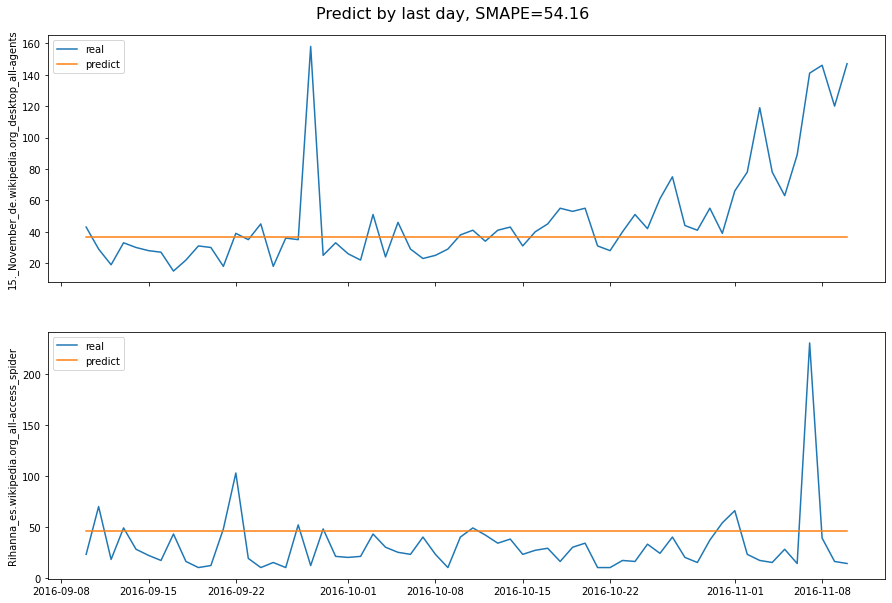

In [ ]:
plot_real_predict(prediction_last_day, 'Predict by last day')

### Median baseline

Потрібно зробити прогноз на основі медіани за останні **30** днів з `train`. 

А потім покращити передбачення використовуючи інформацію вихідний це чи ні (скористайтеся функцією [dayofweek](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DatetimeIndex.dayofweek.html) ) та різні вікна для підрахунку медіани (7 днів, 60 днів тощо)

Вам допоможе функція `pd.groupby()` (https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.groupby.html)

Function to predict the number of visits based on the median of the last days

In [ ]:
def predict_median(predict_step: int, train=train, test=test) -> pd.DataFrame:
    last_date = train['date'].max()
    predict_length = pd.to_timedelta(predict_step, unit='day')
    previous_date = last_date - predict_length
    train_mean = (train
            [(train['date'] >= previous_date)
            & (train['date'] <= last_date)
            ].groupby(['Page'], as_index=False)['Visits'].median().
            rename(columns={'Visits': 'pred_Visits'})
            )
    return pd.merge(test, train_mean, on='Page', how='left') 

In [ ]:
prediction_median_30_day = predict_median(predict_step=30)
pandas_smape(prediction_median_30_day)

51.74728528812927

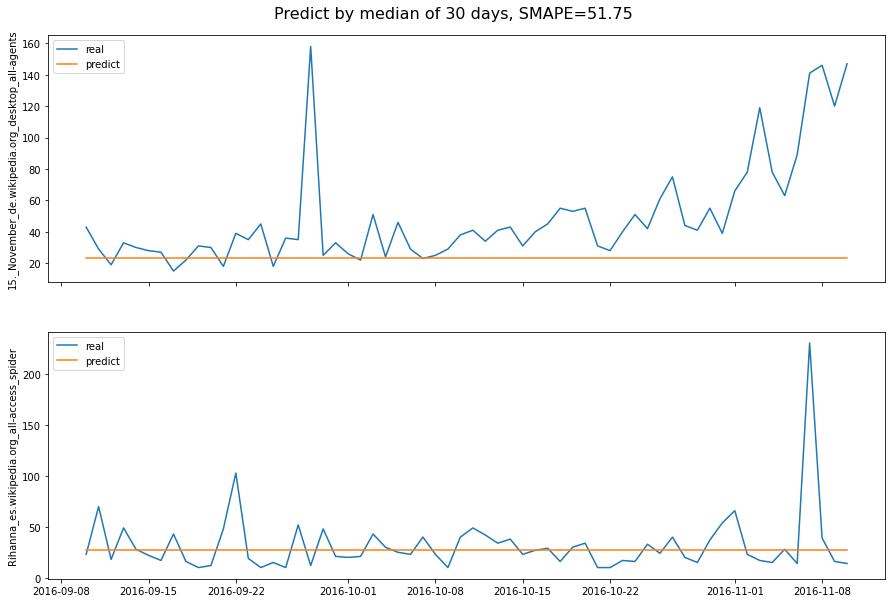

In [ ]:
plot_real_predict(prediction_median_30_day, 'Predict by median of 30 days')

In [ ]:
prediction_median_60_day = predict_median(predict_step=60)
pandas_smape(prediction_median_60_day)

51.71672283515134

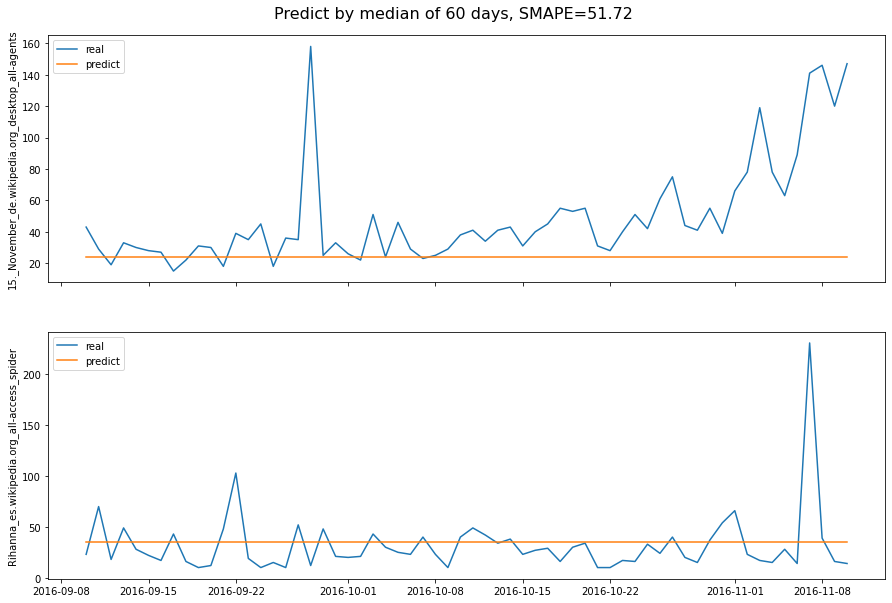

In [ ]:
plot_real_predict(prediction_median_60_day, 'Predict by median of 60 days')

In [ ]:
prediction_median_365_day = predict_median(predict_step=365)
pandas_smape(prediction_median_365_day)

49.94038972356046

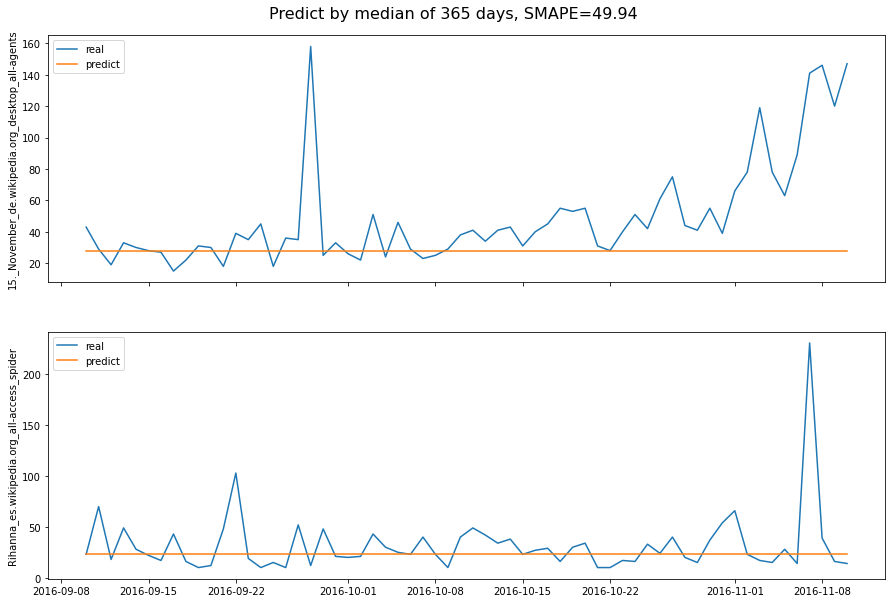

In [ ]:
plot_real_predict(prediction_median_365_day, 'Predict by median of 365 days')

In [ ]:
prediction_median_7_day = predict_median(predict_step=7)
pandas_smape(prediction_median_7_day)

50.09678254308392

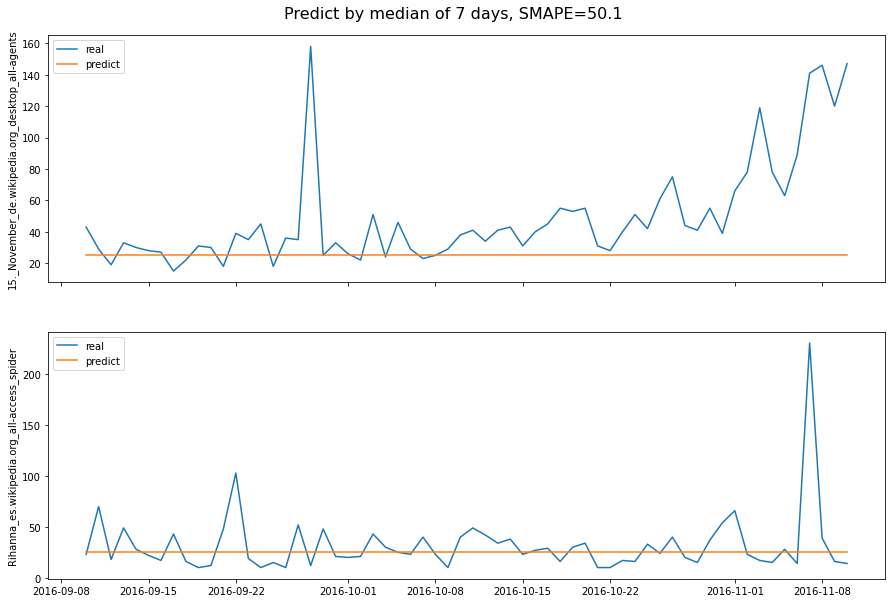

In [ ]:
plot_real_predict(prediction_median_7_day, 'Predict by median of 7 days')

Use information about days of week

In [ ]:
train['dayofweek'] = train['date'].dt.dayofweek


In [ ]:
train_dayofweek = train.groupby(['Page', 'dayofweek'], as_index=False)['Visits'].median().rename(columns={'Visits': 'pred_Visits'})
train_dayofweek.head()

,Page,dayofweek,pred_Visits
0,15._November_de.wikipedia.org_desktop_all-agents,0,30.0
1,15._November_de.wikipedia.org_desktop_all-agents,1,28.0
2,15._November_de.wikipedia.org_desktop_all-agents,2,31.0
3,15._November_de.wikipedia.org_desktop_all-agents,3,28.0
4,15._November_de.wikipedia.org_desktop_all-agents,4,27.0


In [ ]:
test['dayofweek'] = test['date'].dt.dayofweek
test.head()

,Page,date,Visits,dayofweek
0,15._November_de.wikipedia.org_desktop_all-agents,2016-09-10,43.0,5
1,2012_(film)_fr.wikipedia.org_all-access_spider,2016-09-10,6.0,5
2,2016_FIFA_U-20女子ワールドカップ_ja.wikipedia.org_all-a...,2016-09-10,4.0,5
3,2016_UEFA_Europa_League_Final_en.wikipedia.org...,2016-09-10,15.0,5
4,2016_in_video_gaming_en.wikipedia.org_all-acce...,2016-09-10,101.0,5


In [ ]:
prediction_dayofweek = pd.merge(test, train_dayofweek, how='left', on=['Page', 'dayofweek'])
pandas_smape(prediction_dayofweek)

50.464337275834566

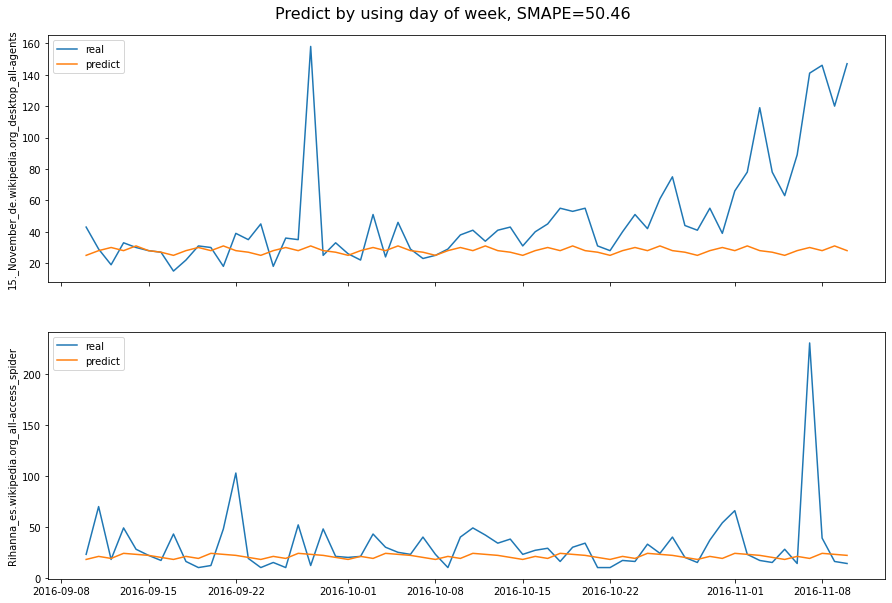

In [ ]:
plot_real_predict(prediction_dayofweek, 'Predict by using day of week')

Use information about weekdays and weekends

In [ ]:
train_weekend = train[['Page', 'dayofweek', 'Visits']].copy()
train_weekend.sample(3)

,Page,dayofweek,Visits
273307,Benito_Juárez_es.wikipedia.org_all-access_all-...,6,3327.0
357685,渡邊直美_zh.wikipedia.org_all-access_spider,4,6.0
340671,ヒグラシ_ja.wikipedia.org_mobile-web_all-agents,0,276.0


In [ ]:

train_weekend['is_weekend'] = np.where((train_weekend['dayofweek'] == 5) | (train_weekend['dayofweek'] == 6), True, False)
train_weekend.sample(3)

,Page,dayofweek,Visits,is_weekend
8276,三峡大坝防洪能力误读事件_zh.wikipedia.org_desktop_all-agents,3,6.0,False
150067,中井りん_ja.wikipedia.org_desktop_all-agents,0,331.0,False
344436,レディー・ガガ_ja.wikipedia.org_all-access_all-agents,4,786.0,False


In [ ]:

train_weekend = train_weekend.groupby(['Page', 'is_weekend'], as_index=False)['Visits'].median().rename(columns={'Visits': 'pred_Visits'})
train_weekend.sample(3)

,Page,is_weekend,pred_Visits
999,San_Carlos_de_Bariloche_es.wikipedia.org_all-a...,True,526.0
216,Chelsea_Manning_en.wikipedia.org_all-access_sp...,False,53.5
906,Phabricator/Project_management_www.mediawiki.o...,False,6.0


In [ ]:
test['is_weekend'] = np.where((test['dayofweek'] == 5) | (test['dayofweek'] == 6), True, False)
test.sample(5)

,Page,date,Visits,dayofweek,is_weekend
377,Loretta_Lynn_en.wikipedia.org_all-access_spider,2016-09-10,37.0,5,True
29517,Mike_Posner_en.wikipedia.org_all-access_spider,2016-10-11,8.0,1,False
39517,Carson_Wentz_en.wikipedia.org_all-access_spider,2016-10-22,16.0,5,True
26727,Olympic_symbols_en.wikipedia.org_mobile-web_al...,2016-10-08,610.0,5,True
34536,Южный_парк_ru.wikipedia.org_desktop_all-agents,2016-10-16,1009.0,6,True


In [ ]:
prediction_weekend = pd.merge(test, train_weekend, how='left', on=['Page', 'is_weekend'])
pandas_smape(prediction_weekend)

50.586109629461475

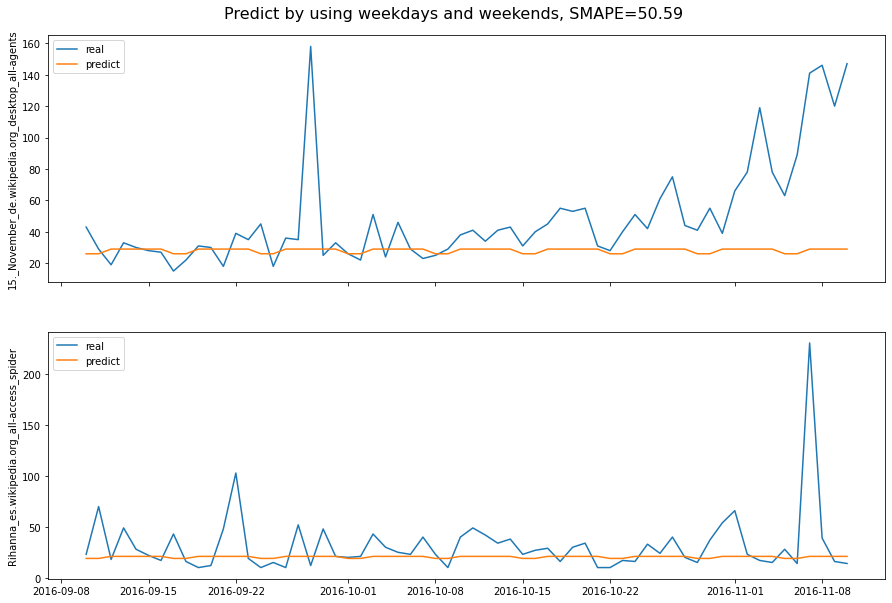

In [ ]:
plot_real_predict(prediction_weekend, 'Predict by using weekdays and weekends')